In [63]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance
import cv2


def show_comparison(original, modified, original_name, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray")
    ax1.set_title(original_name)
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

(512, 512)
int16


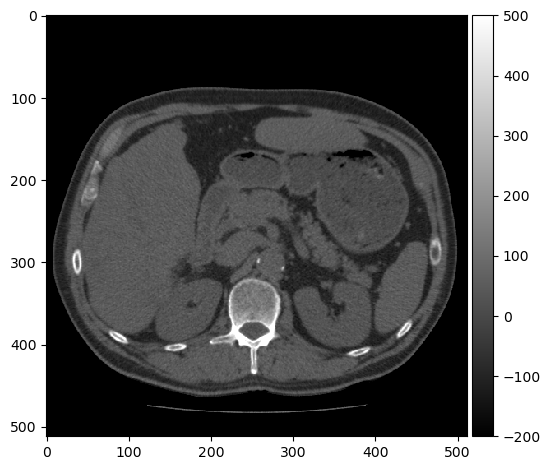

In [64]:
# Open the DICOM file
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

# Show the image
io.imshow(img, cmap="gray", vmin=-200, vmax=500)
io.show()

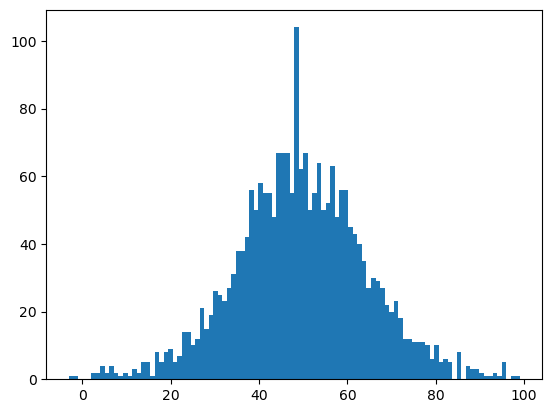

In [65]:
# Value of the pixels in the spleen
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]

# Show the histogram of the spleen values
plt.hist(spleen_values, bins=100)
plt.show()

t_1 =  38.0
t_2 =  61.0


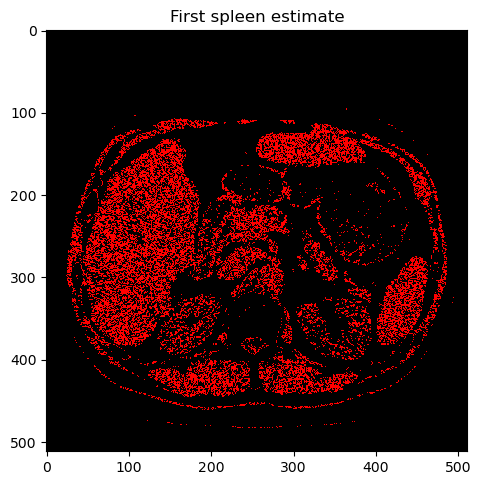

In [66]:
# Show spleen stimate

t_1 = np.percentile(spleen_values, 20)
t_2 = np.percentile(spleen_values, 80)

print("t_1 = ", t_1)
print("t_2 = ", t_2)

spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

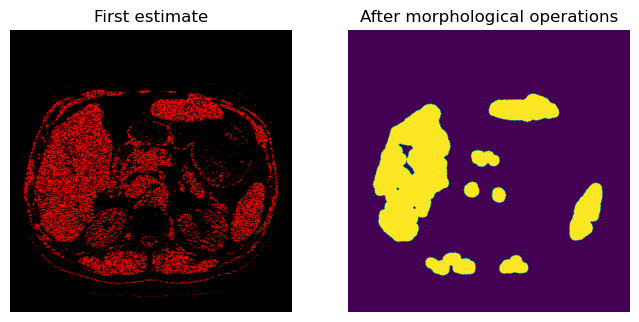

In [67]:
# Apply morphological operations
footprint = disk(2)
closed = binary_closing(spleen_estimate, footprint)

footprint = disk(10)
opened = binary_opening(closed, footprint)

# Show the result
show_comparison(spleen_label_colour, opened, "First estimate", "After morphological operations")

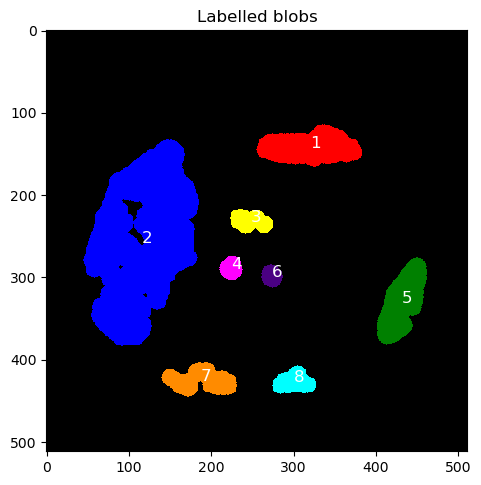

In [68]:
# Blob detection
label_image = measure.label(opened)
label_image_colour = label2rgb(label_image)
io.imshow(label_image_colour)

# Put numbers on the blobs
for region in measure.regionprops(label_image):
    plt.text(region.centroid[1], region.centroid[0], str(region.label), color='white', fontsize=12)
plt.title("Labelled blobs")
io.show()

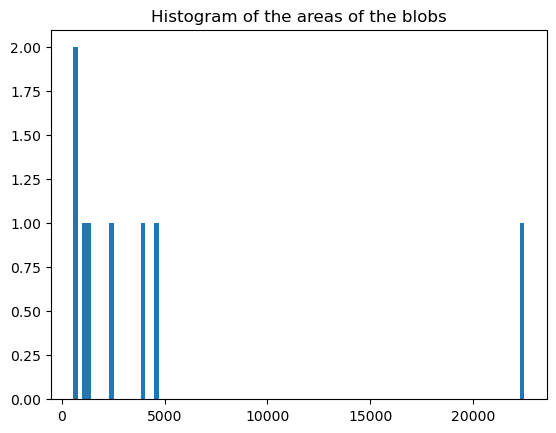

In [69]:
# Properties of the spleen
spleen_properties = measure.regionprops(label_image)

# Show histogram of the area of the blobs
areas = []
for region in spleen_properties:
    areas.append(region.area)
plt.hist(areas, bins=100)
plt.title("Histogram of the areas of the blobs")
plt.show()


Areas:  [4551, 22465, 1194, 629, 3918, 568, 2509, 1283]


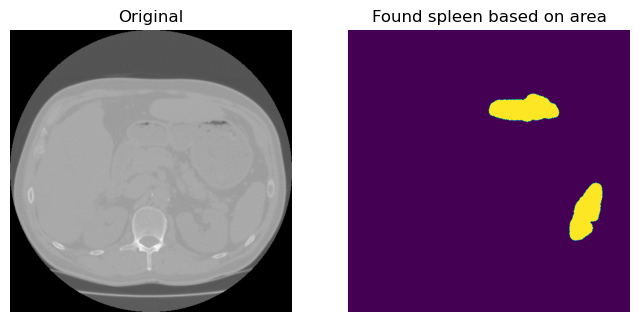

In [70]:
# Get the areas of the blobs
areas = []
for region in spleen_properties:
	areas.append(region.area)

print("Areas: ", areas)

# Blob classification by area (min and max)
min_area = 2510
max_area = 5000

# Create a copy of the label_img
label_img_filter = label_image.copy()
for region in spleen_properties:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0

# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Original', 'Found spleen based on area')

Text(0.5, 1.0, 'Labelled blobs')

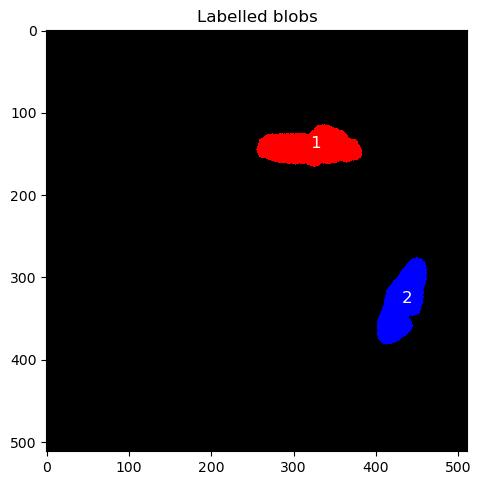

In [71]:
# Convert i_area to a label image
label_image = measure.label(i_area)

# Put numbers on the blobs
for region in measure.regionprops(label_image):
    plt.text(region.centroid[1], region.centroid[0], str(region.label), color='white', fontsize=12)

# Show the result
label_image_colour = label2rgb(label_image)
io.imshow(label_image_colour)
plt.title("Labelled blobs")

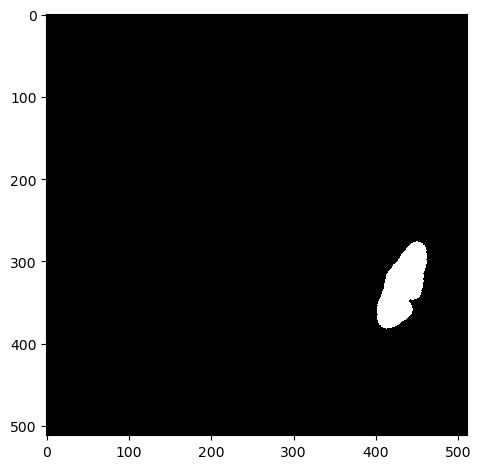

In [72]:
import cv2
import numpy as np

# Assuming label_image is a binary image where blobs are non-zero

# Convert label_image to binary format with data type np.uint8
_, label_image = cv2.threshold(label_image.astype(np.uint8), 0, 255, cv2.THRESH_BINARY)

# Find contours of the blobs in the label_image
contours, _ = cv2.findContours(label_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an output image with the same size as label_image
output = np.zeros_like(label_image)


for contour in contours:
    # Calculate the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Check the aspect ratio of the bounding box
    aspect_ratio = float(w) / h
    
    # If the aspect ratio is less than 1, it means the blob is more vertical
    # Hence, we draw that contour on the output image
    if aspect_ratio < 1:
        cv2.drawContours(output, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)

# Show the result
io.imshow(output)


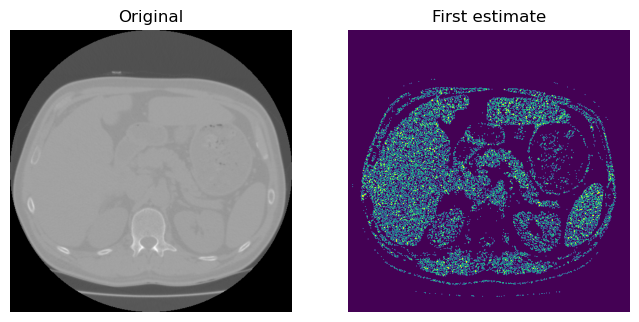

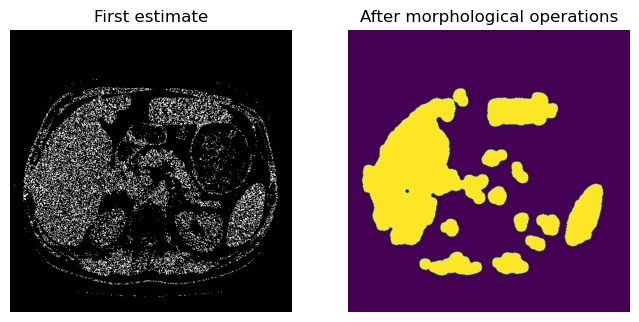

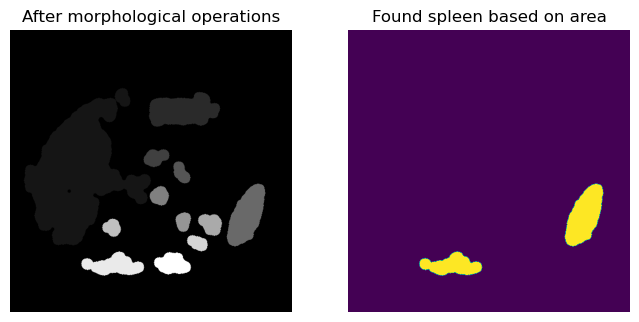

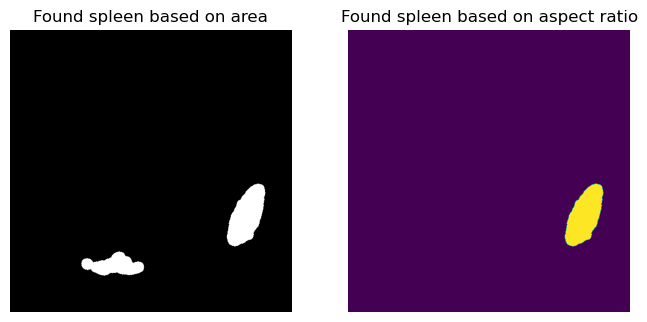

In [100]:
# Create a function, called spleen_finder, that takes a CT image as input and returns a binary image with the spleen

def spleen_finder(img):
    # First estimate
    t_1 = 38
    t_2 = 51
    spleen_estimate = (img > t_1) & (img < t_2)
    show_comparison(img, spleen_estimate, "Original", "First estimate")

    # Apply morphological operations
    footprint = disk(3)
    closed = binary_closing(spleen_estimate, footprint)
    footprint = disk(10)
    opened = binary_opening(closed, footprint)
    show_comparison(spleen_estimate, opened, "First estimate", "After morphological operations")

    # Blob detection
    label_image = measure.label(opened)

    # Areas of the blobs
    areas = []
    for region in measure.regionprops(label_image):
        areas.append(region.area)

    # Blob classification by area (min and max)
    min_area = 2000
    max_area = 5000

    # Create a copy of the label_img
    label_img_filter = label_image.copy()

    for region in measure.regionprops(label_image):
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area:
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0

    # Create binary image from the filtered label image
    i_area = label_img_filter > 0

    # Show the result
    show_comparison(label_image, i_area, 'After morphological operations', 'Found spleen based on area')

    # Convert i_area to a label image
    label_image = measure.label(i_area)

    # Convert label_image to binary format with data type np.uint8
    _, label_image = cv2.threshold(label_image.astype(np.uint8), 0, 255, cv2.THRESH_BINARY)

    # Find contours of the blobs in the label_image
    contours, _ = cv2.findContours(label_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an output image with the same size as label_image
    output = np.zeros_like(label_image)

    for contour in contours:
        # Calculate the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Check the aspect ratio of the bounding box
        aspect_ratio = float(w) / h
        
        # If the aspect ratio is less than 1, it means the blob is more vertical
        # Hence, we draw that contour on the output image
        if aspect_ratio < 1:
            cv2.drawContours(output, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)

    # Show comparison between the i_area and the output
    img_vertical = output.copy()
    show_comparison(i_area, img_vertical, 'Found spleen based on area', 'Found spleen based on aspect ratio')





    


# Open an image
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Test3.dcm')
img = ct.pixel_array
spleen_finder(img)